<a href="https://colab.research.google.com/github/antounes/cv/blob/main/02a_machine_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Image Classification Using a Linear Model

## Standardise Data Collection

We're addressing a hard problem where the flower images are all collected in real-world conditions. However, in practice, you can often make a machine perception problem easier by standardising how the images are collected. For example, you could specify that your images have to be collected in controlled conditions, with flat lightning, and at a consistent zoom. This is common in the manufacturing industry $-$ factory conditions can be precisely specified. It is also common to design the scanner in such a way that an object can be placed in only one orientation. As a machine learning practitioner, you should be on the lookout for ways to make machine perception problems easier. This is not cheating $-$ it's the smart thing to do to set yourself up for succcess.

Keep in mind, however, that your training dataset has to reflect the conditions under which your model will be required to make predictions. If your model is trained onyl on photographs of flowers taken by professional photographers, it will probably do poorly on photographs taken by amateurs whose lighting, zoom, and framing choices are likely to be different.

## Enable GPU

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

2.7.0


SystemError: ignored

## Examine the Images

Let"s see the first five lines of the `train_set.csv`. Each line consists of a JPEG filename and the type of flower it is.

In [3]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # Read the file to a tensor as a sequence of bytes
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Convert 3D uint8 to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualising Image Data

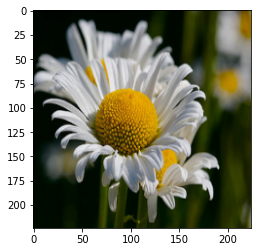

In [5]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


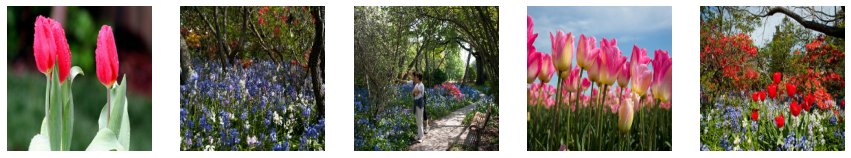

In [6]:
# Notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis("off")

In [7]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    "/")[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

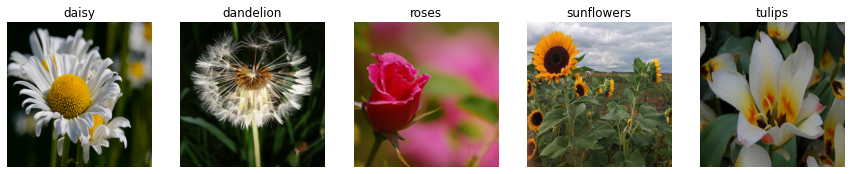

In [8]:
f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis("off")

## A Simple Rule-Based Model 

In [9]:
# Let's get the average color of RGB values in the different types of flowers and then classify an unknown image as belonging to the closest centroid

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  return img, label_string

dataset = tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
).map(decode_csv)

# Testing: print out the average pixel value for each channel of the first three images in the training dataset
for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1])
  print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.35889465 0.36257476 0.26932985], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278505 0.32278505 0.32278505], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397638 0.13298166 0.07217269], shape=(3,), dtype=float32)


In [10]:
# Let's define our prediction system as a class (!)

class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0

  def update(self, value):
    self.sum_so_far += value
    self.count_so_far += 1
    if self.count_so_far % 100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return "{} {}".format(self.label, self.centroid().numpy())

class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES
        }
    
  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf8")
      avg = tf.reduce_mean(img, axis=[0, 1])
      self.centroids[label].update(avg)

  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1])
    best_label = ""
    best_diff = 999
    for k, v in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - v.centroid()))
      if diff < best_diff:
        best_diff = diff
        best_label = k
    return best_label

  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode("utf8")
      predicted = self.predict(img)
      if correct == predicted:
        num_correct += 1
      total_images += 1
    accuracy = num_correct / total_images
    return(accuracy)

In [11]:
rule = CentroidRule()

train_dataset = tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
    ).map(decode_csv).take(500)

eval_dataset = tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
    ).map(decode_csv).take(500)

rule.fit(train_dataset)

print(rule.centroids["daisy"])
print(rule.centroids["roses"])

dandelion 100
tulips 100
daisy [0.44554454 0.44968542 0.3594966 ]
roses [0.46776465 0.37675518 0.31471258]


In [12]:
# This is how the model would be used to make a prediction
filename = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

dandelion


## A Linear Model Using Keras

In [13]:
# What if we apply different weights to each of the pixels ?

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
    ).map(decode_csv).batch(10)

eval_dataset = tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
    ).map(decode_csv).batch(10)

# Linear model
model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
     tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


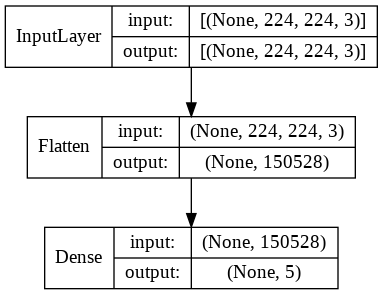

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [16]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 246s 744ms/step - loss: 18.0111 - accuracy: 0.3436 - val_loss: 25.2565 - val_accuracy: 0.3973
Epoch 2/10
330/330 [==============================] - 178s 540ms/step - loss: 14.7576 - accuracy: 0.4097 - val_loss: 17.1007 - val_accuracy: 0.4081
Epoch 3/10
330/330 [==============================] - 139s 421ms/step - loss: 14.7917 - accuracy: 0.4482 - val_loss: 25.2129 - val_accuracy: 0.3216
Epoch 4/10
330/330 [==============================] - 135s 408ms/step - loss: 13.1445 - accuracy: 0.4733 - val_loss: 26.2214 - val_accuracy: 0.3676
Epoch 5/10
330/330 [==============================] - 139s 420ms/step - loss: 11.3795 - accuracy: 0.5127 - val_loss: 34.8407 - val_accuracy: 0.3649
Epoch 6/10
330/330 [==============================] - 146s 441ms/step - loss: 14.1714 - accuracy: 0.5142 - val_loss: 25.9746 - val_accuracy: 0.3757
Epoch 7/10
330/330 [==============================] - 133s 403ms/step - loss: 13.7483 - accuracy: 0.5321 - val_l

In [17]:
import matplotlib
matplotlib.rcParams.update({"font.size": 20})

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric])
    ax[idx].set_xlabel("Epochs")
    ax[idx].plot(history.history["val_"+metric], ls="dashed");
    ax[idx].legend([metric, "val_"+metric], fontsize=20)

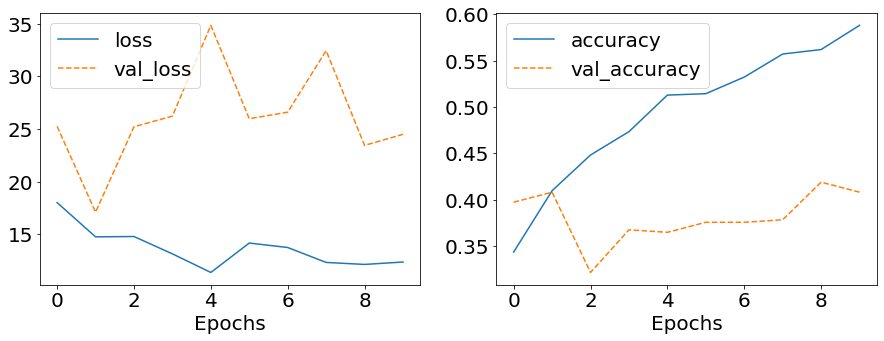

In [18]:
training_plot(["loss", "accuracy"], history)

[0.09405971 0.0570501  0.8488902 ]
[0.04838873 0.0721875  0.8794238 ]


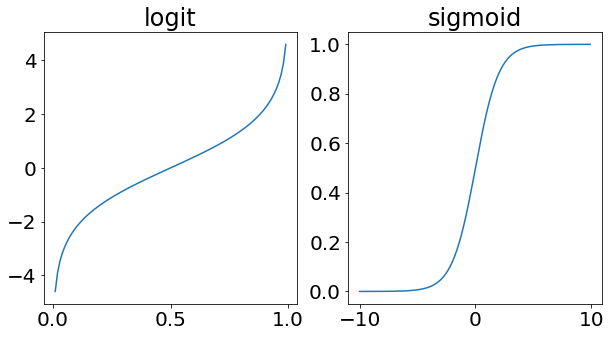

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y)
ax[1].set_title("sigmoid")

print(tf.math.softmax([-1.0, -1.5, 1.2]).numpy())
print(tf.math.softmax([0.1, 0.5, 3.0]).numpy())

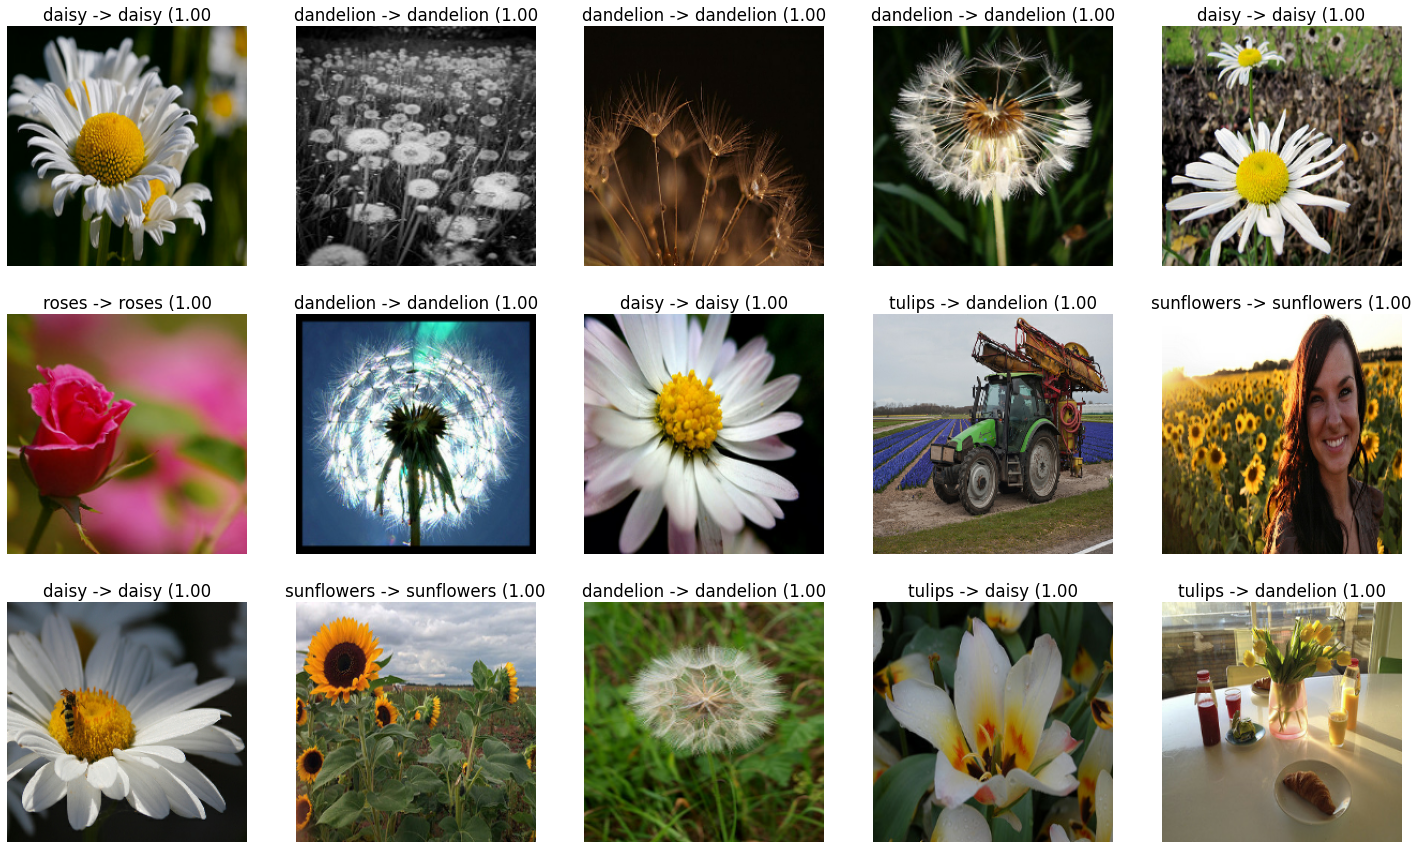

In [21]:
# Call model.predict() on a few images in the evaluation dataset

def plot_predictions(filename):
  matplotlib.rcParams.update({"font.size": 14})
  f, ax = plt.subplots(3, 5, figsize=(25, 15))
  dataset = tf.data.TextLineDataset(filename).map(decode_csv)
  
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title("{} -> {} ({:.2f}".format(label, pred_label, prob))
    ax[idx//5, idx%5].axis("off")
  
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

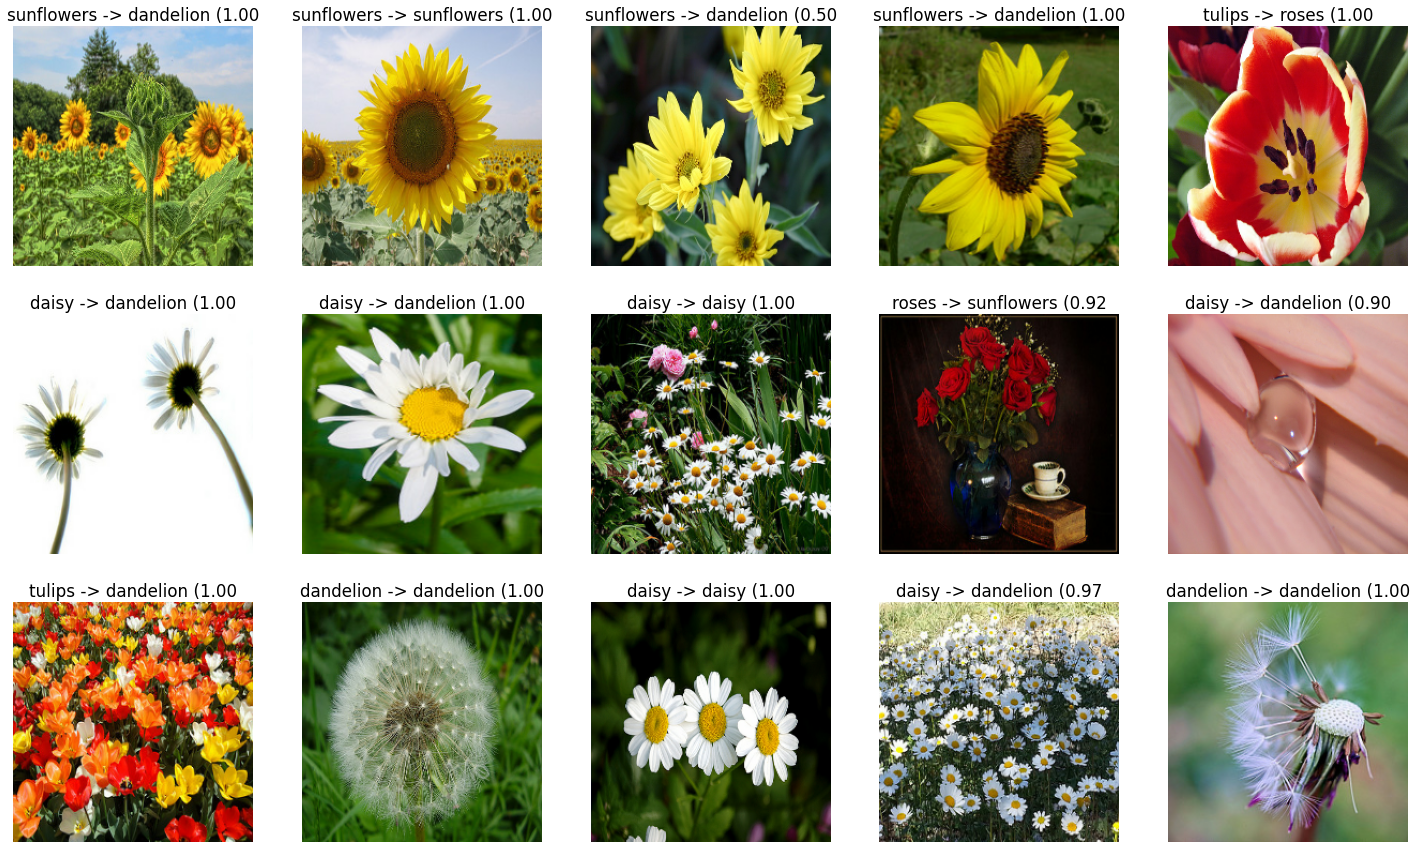

In [22]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

Scaling weights for daisy in -0.13175883889198303 to 0.1147606298327446
Scaling weights for dandelion in -0.11086399108171463 to 0.1406020224094391
Scaling weights for roses in -0.10770900547504425 to 0.11666936427354813
Scaling weights for sunflowers in -0.15859165787696838 to 0.15483427047729492
Scaling weights for tulips in -0.12124204635620117 to 0.12111334502696991


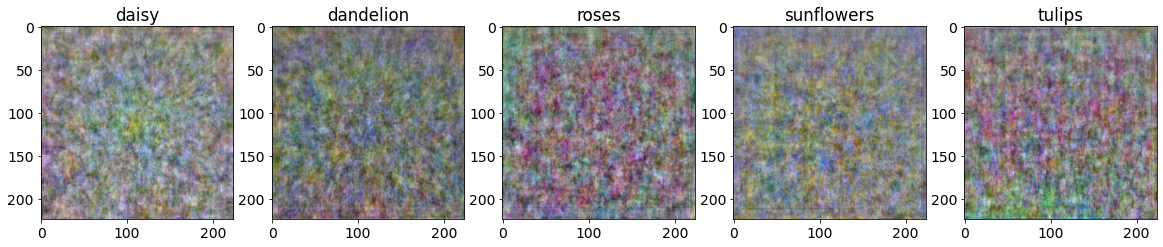

In [25]:
def show_trained_weights(model):
  # CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias
  
  f, ax = plt.subplots(1, 5, figsize=(20, 20))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(flower_name, min_wt, max_wt))
    weights = (weights - min_wt) / (max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS));
    ax[flower].set_title(flower_name);

show_trained_weights(model)